## Формирование dataset-a

In [143]:
import os
import pandas as pd

""" чтение файлов """
def fread(path):
    f = open(path)
    content = f.read()
    f.close()
    return content

""" формирование df """
datapath = "./data/"
df = pd.DataFrame(columns=["docname", "text"])
for fpath in os.listdir(datapath):
    text = fread(datapath + fpath)
    df.loc[len(df.index)] = [fpath, text]
df["gender"] = df.apply(
    lambda row: 0 if str(row["docname"]).startswith("M") else 1, axis=1
)

""" перемешивание строк """
df = df.sample(frac=1).reset_index(drop=True)
df.info()
display(df.head(), df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   docname  66 non-null     object
 1   text     66 non-null     object
 2   gender   66 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ KB


,docname,text,gender
0,FМаврина-3.txt,Проблема: Появление новых пандемий: появление ...,1
1,MБекленищев-2.txt,Проблема: Миграция и беженцы. Решение: Разрабо...,0
2,MГордеев-1.txt,Проблема: Отсутствие деятельности мозга. “Заче...,0
3,FМаврина-1.txt,Проблема: Демографические изменения: быстрый р...,1
4,MФедотов-2.txt,"Проблема: Бедные беднее, богатые богаче, как п...",0


,docname,text,gender
61,FСемеленова-1.txt,Проблема: Недостаток пресной воды. Решение: Ин...,1
62,MГисматуллин-2.txt,Проблема: Проблема “отсутствия” культуры в чел...,0
63,MКуклев-2.txt,Проблема: Голод и нехватка продовольствия. Реш...,0
64,MГордеев-2.txt,Проблема. Ориентированность человека решать то...,0
65,FАлимова-1.txt,"Проблема: Деградация внимания, снижение когнит...",1


## Предобработка набора текстов/фильтрация

In [144]:
import spacy
sp = spacy.load("ru_core_news_lg")

In [145]:
""" токенизация """
tdf = df.copy()
tdf["toks"] = df['text'].apply(lambda row: sp(row.lower())) # понижение регистра

""" удаление токенов длино 1"""
tdf["toks"] = tdf["toks"].apply(
    lambda row: [token for token in row if len(token) > 1]
)

""" удаление стоп слов """
tdf["toks"] = tdf['toks'].apply(
    lambda row: [token for token in row if not token.is_stop and not token.is_punct and not token.is_digit]
)

""" удаление небкувенных символов """
tdf["toks"] = tdf["toks"].apply(lambda row: [token for token in row if token.is_alpha])

In [146]:
""" Выделение частей речи (Pos tagging)"""
tdf["pos"] = tdf["toks"].apply(
    lambda row: [token.morph for token in row]
)

""" нормализация на основе леммантизации"""
tdf['toks'] = tdf["toks"].apply(
    lambda row: [token.lemma_ for token in row]
)

In [147]:
""" Слияние токенов и pos-tags """
def merge(toks, poses):
    result = []
    for tok, pos in zip(toks, poses):
        ntok = tok + ' ' + f"{pos}"
        result.append(ntok)
    return result
tdf["toks_pos"] = tdf.apply(lambda row: merge(row.toks, row.pos), axis=1)

## Индексирование текста на основе частотного портрета
Частотный портрет позволяет учитывать различные взаимодействия между словами, в том числе и в разных документах

In [148]:
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

In [149]:
def dummy(tokens):
    return tokens

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=dummy, preprocessor=dummy)
tfidf_matrix = sparse.csr_matrix(tfidf_vectorizer.fit_transform(tdf["toks_pos"].values))
tdf["vector"] = tdf.apply(
    lambda row: tfidf_matrix.toarray()[row.name],axis=1
)

c:\Users\Ilfe\MaiProject\text-analysis-notebook\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Решение задачи кластеризации

In [150]:
from utils_clusters import get_linkage_matrix, run_agglomerative
from visual import draw_dendrogram
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans

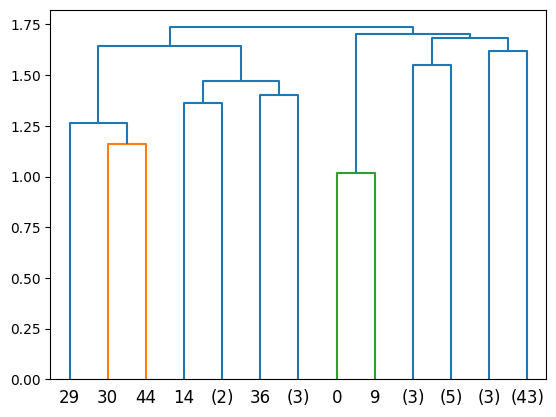

In [151]:
""" Иерархическая агломеративная кластеризация  & дендрограмма """
tree = run_agglomerative(tdf["vector"].to_list())
linkage_matrix = get_linkage_matrix(tree)
draw_dendrogram(linkage_matrix)

Дендрограмма выше показывает, где примерно можно срезать расстояни элементов до центров кластеров.
> В данном случае мы можем взять примерно 7 кластеров для использования уже неиерархической кластеризации

## Четкая неиерархическая кластеризация

In [152]:
clusters = 7
kmeans = KMeans(n_clusters=clusters, random_state=9)
kmeans.fit(sparse.csc_matrix(list(tdf["vector"])))
for cid in range(clusters):
    cindeces = numpy.where(kmeans.labels_ == cid)[0]
    print(f"Кластер {cid + 1} ({len(cindeces)}):")
    cdocs = [tdf.iloc[idx]["docname"] for idx in cindeces]
    print("; ".join(cdocs))
    print("--------")

Кластер 1 (6):
FМаврина-3.txt; FЗенина-3.txt; MБекленищев-3.txt; MМихайлишин-1.txt; MКаштанов-1.txt; FИгнаткина-2.txt
--------
Кластер 2 (4):
FАпарян-2.txt; FАлимова-2.txt; FЗенина-1.txt; FЯльмеева-3.txt
--------
Кластер 3 (20):
MФедотов-2.txt; FКороткова-3.txt; FЯльмеева-1.txt; FИгнаткина-1.txt; FСемеленова-2.txt; MГисматуллин-1.txt; FКороткова-2.txt; MКаштанов-3.txt; FСемеленова-3.txt; MЗиновьев-1.txt; MКаштанов-2.txt; FМусаткина-1.txt; MКуклев-3.txt; MЗиновьев-2.txt; MЗиновьев-3.txt; MГисматуллин-3.txt; FСемеленова-1.txt; MГисматуллин-2.txt; MКуклев-2.txt; MГордеев-2.txt
--------
Кластер 4 (16):
MГруздев-3.txt; MЧегодаев-2.txt; MМихайлишин-3.txt; MГруздев-1.txt; FАпарян-1.txt; MГаврилов-1.txt; FАпарян-3.txt; MШарафутдинов-3.txt; MМихайлишин-2.txt; FМусаткина-3.txt; MЧегодаев-3.txt; FАлимова-3.txt; MГруздев-2.txt; MГаврилов-2.txt; FЯльмеева-2.txt; FАлимова-1.txt
--------
Кластер 5 (5):
MГаврилов-3.txt; FМаврина-2.txt; MФедотов-3.txt; MГордеев-3.txt; FИгнаткина-3.txt
--------
Кластер 

## Итоги
**Для Неиерархической кластеризации основанной на частотном портрете:**
1. Кластер 1(6): Вирусы
2. Кластер 2(4): Все уникальны
3. Кластер 3(20): Общественный проблемы, проблемы энергии и ресурсов 
4. Кластер 4(16): Демография и мигранты
5. Кластер 5(5): Ресурсы
6. Кластер 6(7): Демография
6. Кластер 7(8): Климат

> В заключение можно добавить что задача была решена не очень хорошо, т.к. многие документы были отнесены не совсем корректно. Необходмо эксперементировать, пробовать другие методы.